## The Data

**Source: https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line**

**Monthly milk production: pounds per cow. Jan 62 - Dec 75**

Import numpy pandas and matplotlib

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

**Use pandas to read the csv of the monthly-milk-production.csv file and set index_col='Month'**

Mounting google drive to read the csv file. 

Alternatively, you can download the csv file to your local disk drive 

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
milk = pd.read_csv("gdrive/My Drive/dataML/monthly-milk-production.csv",index_col='Month')

#milk = pd.read_csv("monthly-milk-production.csv",index_col='Month')

In [4]:
milk.tail()

,Milk Production
Month,
1975-08-01 01:00:00,858.0
1975-09-01 01:00:00,817.0
1975-10-01 01:00:00,827.0
1975-11-01 01:00:00,797.0
1975-12-01 01:00:00,843.0


In [5]:
type(milk.index[0])

str

**Make the index a time series by using:**

    milk.index = pd.to_datetime(milk.index)

In [0]:
milk.index = pd.to_datetime(milk.index)

In [7]:
type(milk.index[12])

pandas._libs.tslibs.timestamps.Timestamp

In [8]:
milk.head()

,Milk Production
Month,
1962-01-01 01:00:00,589.0
1962-02-01 01:00:00,561.0
1962-03-01 01:00:00,640.0
1962-04-01 01:00:00,656.0
1962-05-01 01:00:00,727.0


In [9]:
milk.keys()

Index(['Milk Production'], dtype='object')

** Plot out the time series data. **

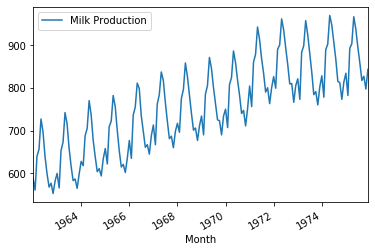

In [10]:
milk.plot()

### Train Test Split

** Let's attempt to predict a year's worth of data. (12 months or 12 steps into the future) **


In [11]:
milk.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 1962-01-01 01:00:00 to 1975-12-01 01:00:00
Data columns (total 1 columns):
Milk Production    168 non-null float64
dtypes: float64(1)
memory usage: 2.6 KB


In [12]:
len(milk)

168

In [0]:
train_set= milk.head((1976-1962-1)*12)

In [0]:
test_set = milk.tail(12)

### Scale the Data

** Use sklearn.preprocessing to scale the data using the MinMaxScaler. Remember to only fit_transform on the training data, then transform the test data. You shouldn't fit on the test data as well, otherwise you are assuming you would know about future behavior!**

In [0]:
from sklearn.preprocessing import MinMaxScaler

In [0]:
scaler = MinMaxScaler()

In [0]:
train_scaled = scaler.fit_transform(train_set)

In [0]:
test_scaled = scaler.transform(test_set)

## Build Training Data

* X_train: Past 12 monthes productions, shape: (-1,12)
* Y_train: Future 1 month productions, shape:(-1, 1) 
* Shift the window to get more trainning data

In [0]:
def build_train_data(data, past_monthes = 12, future_monthes = 1):
  X_train, Y_train = [],[]
  
  for i in range(data.shape[0] + 1 - past_monthes - future_monthes):
    X_train.append(np.array(data[i:i + past_monthes]))
    Y_train.append(np.array(data[i + past_monthes:i + past_monthes + future_monthes]))
    
  return np.array(X_train).reshape([-1,12]), np.array(Y_train).reshape([-1,1])
   

In [0]:
x, y = build_train_data(train_scaled)

In [21]:
print('x shape;', x.shape, 'y shape: ', y.shape)

x shape; (144, 12) y shape:  (144, 1)


Take a look at the data

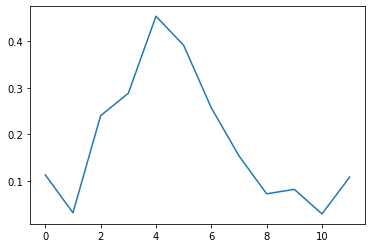

In [22]:
plt.plot(x[12])

## Tensorflow 2.0

In [23]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf


In [0]:
RNN_CELLSIZE = 10
SEQLEN = 12
BATCHSIZE = 1
LR = 0.001

In [0]:
class GRUModel(tf.keras.Model):
  def __init__(self, batch_size, seq_length, cell_size):
    super().__init__()
    self.batch_size = batch_size
    self.seq_length = seq_length
    self.cell_size = cell_size
    
    self.layer1 = tf.keras.layers.Reshape((self.seq_length,1), batch_size = self.batch_size)
    self.layer_GRU = tf.keras.layers.GRU(self.cell_size, return_sequences=True)
    self.layer_last_GRU = tf.keras.layers.GRU(self.cell_size)
    self.layer_dense = tf.keras.layers.Dense(1)
  
  def call(self, inputs):
    x = self.layer1(inputs)
    x = self.layer_GRU(x)
    x = self.layer_last_GRU(x)
    output = self.layer_dense(x)
    return output

In [0]:
model = GRUModel(BATCHSIZE, SEQLEN,RNN_CELLSIZE)
optimizer = tf.keras.optimizers.Adam(learning_rate = LR)

In [46]:
for epoch in range(1000):
  with tf.GradientTape() as tape:
    y_pred = model(x)
    loss = tf.reduce_mean((y_pred - y)**2)
    if epoch%100 == 0:
      print("epoch: {}, loss: {}".format(epoch, loss.numpy()))
  
  grads = tape.gradient(loss, model.variables)
  optimizer.apply_gradients(zip(grads,model.variables))

epoch: 0, loss: 0.0028520694468170404
epoch: 100, loss: 0.002558263950049877
epoch: 200, loss: 0.002333666430786252
epoch: 300, loss: 0.0022316505201160908
epoch: 400, loss: 0.0020229490473866463
epoch: 500, loss: 0.001882405485957861
epoch: 600, loss: 0.0017968474421650171
epoch: 700, loss: 0.0018584158970043063
epoch: 800, loss: 0.0016114676836878061
epoch: 900, loss: 0.0015710649313405156


### Predict Future 
* Use the last 12 monthes data of the train data set to predict the future 12 monthes production 
* Compare the predicted data with the real data in test data set

Get the last 12 monthes data of the train data

In [0]:
train_seed = list(train_scaled[-12:].flatten())

One prediction only generate one predict, we need predict 12 times to get 12 monthes data.

In [0]:
def get_prediction(data_list):
  predict = []
  train_seed = data_list
  for i in range(12):
    x_train = np.array(train_seed[-12:]).reshape(1,12)
    one_predict = model.predict(x_train)[0][0]
    predict.append(one_predict) 
    train_seed.append(one_predict)
   
  return predict, train_seed

In [0]:
predict, train_seed = get_prediction(train_seed)

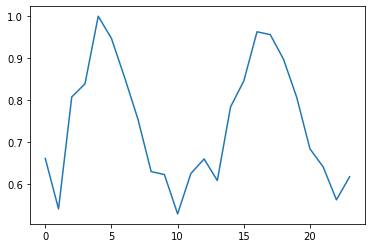

In [50]:
plt.plot(train_seed)

In [0]:
results = scaler.inverse_transform(np.array(predict).reshape(12,1))

In [52]:
test_set['Generated'] = results

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Compare the generated data with the real data

In [53]:
test_set

,Milk Production,Generated
Month,,
1975-01-01 01:00:00,834.0,827.510132
1975-02-01 01:00:00,782.0,806.098389
1975-03-01 01:00:00,892.0,879.101196
1975-04-01 01:00:00,903.0,904.815430
1975-05-01 01:00:00,966.0,953.602356
1975-06-01 01:00:00,937.0,950.758484
1975-07-01 01:00:00,896.0,926.439514
1975-08-01 01:00:00,858.0,888.573364
1975-09-01 01:00:00,817.0,837.547363


In [54]:
type(test_set.index[2])

pandas._libs.tslibs.timestamps.Timestamp

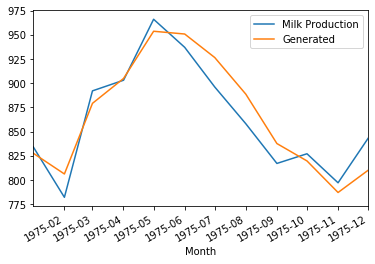

In [55]:
test_set.plot()

### Predict more 
Use the first months data to predict the future 13 years' milk productions and compare with the real data

In [0]:
train_seed = list(train_scaled[:12].flatten())

In [0]:
def get_prediction(data_list):
  predict = []
  train_seed = data_list
  for i in range(12*13):
    x_train = np.array(train_seed[-12:]).reshape(1,12)
    one_predict = model.predict(x_train)[0][0]
    predict.append(one_predict) 
    train_seed.append(one_predict)
   
  return predict, train_seed

In [0]:
predict, train_seed = get_prediction(train_seed)

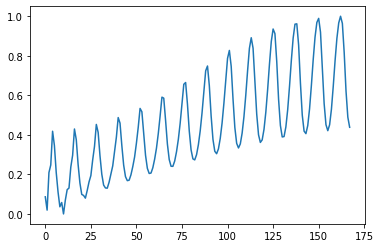

In [59]:
plt.plot(train_seed)

In [0]:
results = scaler.inverse_transform(np.array(train_seed).reshape(-1,1))

In [0]:
milk_predict = milk

In [0]:
milk_predict['Generated'] = results

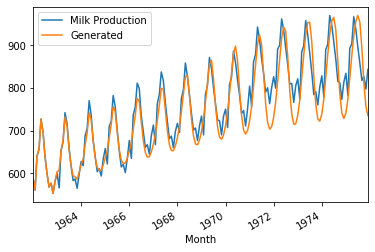

In [63]:
milk_predict.plot()